In [1]:
#required packages
import pandas as pd
import geopandas as gpd
#read in the geospatial data for the statistical sectors of Belgium
gdf = gpd.read_file("statistical_sectors.geojson")

## Leuven Statistical Sectors


<Axes: >

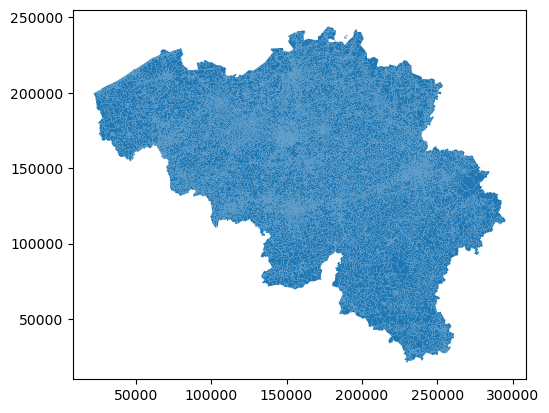

In [2]:
# plot of statistical sectors of Belgium
gdf.plot()

In [104]:
#change of index to that defined by the first column
gdf=gdf.set_index("ogc_fid")

KeyError: "None of ['ogc_fid'] are in the columns"

In [105]:
# view names of all columns in the data frame
print(gdf.columns.tolist())

['cd_sector', 'tx_sector_descr_nl', 'tx_sector_descr_fr', 'tx_sector_descr_de', 'cd_sub_munty', 'tx_sub_munty_nl', 'tx_sub_munty_fr', 'tx_munty_dstr', 'cd_munty_refnis', 'tx_munty_descr_nl', 'tx_munty_descr_fr', 'tx_munty_descr_de', 'cd_dstr_refnis', 'tx_adm_dstr_descr_nl', 'tx_adm_dstr_descr_fr', 'tx_adm_dstr_descr_de', 'cd_prov_refnis', 'tx_prov_descr_nl', 'tx_prov_descr_fr', 'tx_prov_descr_de', 'cd_rgn_refnis', 'tx_rgn_descr_nl', 'tx_rgn_descr_fr', 'tx_rgn_descr_de', 'cd_country', 'cd_nuts_lvl1', 'cd_nuts_lvl2', 'cd_nuts_lvl3', 'ms_area_ha', 'ms_perimeter_m', 'dt_situation', 'geometry', 'area']


In [106]:
# drop unnecessary multilingual labels
gdf_wanted_columns = ["cd_sector","tx_sector_descr_nl", "tx_sub_munty_nl", "tx_munty_descr_nl", 
                                    "tx_adm_dstr_descr_nl", "tx_prov_descr_nl", "tx_rgn_descr_nl", 
                                    "cd_country", 'ms_area_ha', 'geometry']

gdf_nl = gdf[gdf_wanted_columns]

In [107]:
# subsetting by all statistical sectors in the municipality of Leuven
gdf_leuven=gdf_nl[gdf_nl["tx_munty_descr_nl"]=="Leuven"]

In [108]:
# number of instances in the different sub-municipalities which Leuven is comprised of
gdf_leuven["tx_sub_munty_nl"].value_counts()

tx_sub_munty_nl
LEUVEN                            37
KESSEL-LO                         30
HEVERLEE + DEEL VAN BLANDEN       25
WILSELE                           17
DEEL KORBEEK-LO +DEEL HAASRODE     6
DEEL HERENT (WIJGMAAL)             3
Name: count, dtype: int64

<Axes: >

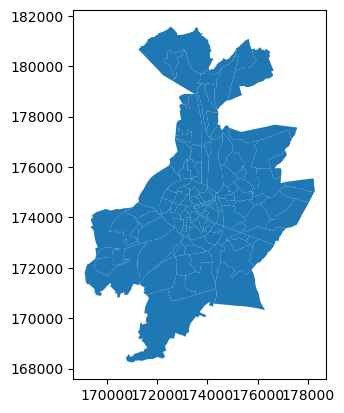

In [109]:
# plot of statistical sector in leuven municipaility
gdf_leuven.plot()

In [110]:
# reading in statistical sector data which contains populations counts
pop_df = pd.read_csv("statistical_sector_data.csv")
# selecting only the useful columns
pop_df=pop_df[["CD_SECTOR", "TOTAL", "TX_DESCR_SECTOR_NL", "TX_DESCR_NL"]]
# subsetting for sectors in Leuven municipality
pop_df=pop_df[pop_df["TX_DESCR_NL"]=="Leuven"]
# dropping incidence of residents whose sector was unknown
pop_df=pop_df.drop(4298, axis=0)
pop_df

,CD_SECTOR,TOTAL,TX_DESCR_SECTOR_NL,TX_DESCR_NL
4180,24062A00-,769,LEUVEN-CENTRUM,Leuven
4181,24062A01-,828,LEI - VISMARKT,Leuven
4182,24062A02-,359,LEUVEN STADSPARK,Leuven
4183,24062A03-,708,DAMIAANPLEIN,Leuven
4184,24062A04-,333,LEUVEN KLINIEK -O.L.VROUW-KERK,Leuven
...,...,...,...,...
4293,24062E774,165,HAASRODE INDUSTRIEZONE,Leuven
4294,24062E790,291,DEN DUIVEL,Leuven
4295,24062F40-,2506,WIJGMAAL-KERN,Leuven
4296,24062F412,570,WIJVELD,Leuven


In [27]:
# merge dataframe with population info with the geodataframe
gdf_pop_leuven = pd.merge(right=pop_df,left=gdf_leuven, right_on="CD_SECTOR", left_on="cd_sector")
# drop unwanted columns
gdf_pop_leuven = gdf_pop_leuven.drop(["TX_DESCR_SECTOR_NL", "TX_DESCR_NL", "cd_sector"], axis = 1)
# calculating population density for visualisation purposes
gdf_pop_leuven["pop_density"] = gdf_pop_leuven["TOTAL"]/gdf_pop_leuven["ms_area_ha"]

In [29]:
# cool interactive map which displays the sectors and their info, coloured by population density
gdf_pop_leuven.explore("pop_density", legend=False)

## Creating a random scattering of First Responders

In [35]:
# calculating total population of leuven
leuven_pop = sum(gdf_pop_leuven["TOTAL"])
# calculating proportion of the population residing in each sector
gdf_pop_leuven["pop_proportion"] = gdf_pop_leuven["TOTAL"]/leuven_pop
gdf_pop_leuven["pop_proportion"]

0      0.007478
1      0.008051
2      0.003491
3      0.006885
4      0.003238
         ...   
113    0.001604
114    0.002830
115    0.024368
116    0.005543
117    0.006642
Name: pop_proportion, Length: 118, dtype: float64

In [85]:
# function which takes as input the desired proporiton of the population who will 
# act as first responders, and outputs a realistic number of FRs in each sector
def fr_pop_proportion(x):
    gdf_pop_leuven["fr_per_sector"]=round(gdf_pop_leuven["pop_proportion"]*x*leuven_pop).astype(int)
    return gdf_pop_leuven["fr_per_sector"]

In [101]:
fr_pop_proportion(0.01)

0       8
1       8
2       4
3       7
4       3
       ..
113     2
114     3
115    25
116     6
117     7
Name: fr_per_sector, Length: 118, dtype: int32

In [103]:
# manipulating the output of our function so that it may be used to generate the
# random points (first responders) for each sector
fr_array = gdf_pop_leuven["fr_per_sector"].to_numpy()
# generating random points
gdf_pop_leuven["fr_loc"] = gdf_pop_leuven.sample_points(size=fr_array, method="uniform", rng=1)
# plotting the sectors and random points on an interactive map
m = gdf_pop_leuven.explore()
gdf_pop_leuven["fr_loc"].explore(m=m, color='red')

C:\Users\Dillon\anaconda3\Lib\site-packages\geopandas\tools\_random.py:83: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  return GeoSeries(candidates[:size]).unary_union
C:\Users\Dillon\anaconda3\Lib\site-packages\geopandas\tools\_random.py:83: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  return GeoSeries(candidates[:size]).unary_union
C:\Users\Dillon\anaconda3\Lib\site-packages\geopandas\tools\_random.py:83: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  return GeoSeries(candidates[:size]).unary_union
C:\Users\Dillon\anaconda3\Lib\site-packages\geopandas\tools\_random.py:83: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLE